In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

pd.set_eng_float_format(accuracy=4, use_eng_prefix=True)

import sys
sys.path.append('..')
from src.utils import get_data

In [2]:
terminals, time_matrix = get_data('../data/')

In [83]:
class Graph:

    def __init__(self, matrix) -> None:
        self.matrix = matrix
        self.root = np.arange(len(matrix))
        self.rank = np.zeros(len(matrix))

        idx = time_matrix.flatten().argsort()
        i, j = idx // len(time_matrix), idx % len(time_matrix)
        edges = np.stack([i, j, time_matrix.flatten()[idx]], axis=1)
        self.edges = edges[edges[:, 2].argsort()][:, :2].astype(int)

    def _find_root(self, label):
        if self.root[label] != label:
            self.root[label] = self._find_root(self.root[label])
        return self.root[label]
        
    def kruskal(self):
        self.mst = []
        for l1, l2 in self.edges:

            root1 = self._find_root(l1)
            root2 = self._find_root(l2)

            if root1 != root2:
                if self.rank[root1] > self.rank[root2]:
                    self.root[root2] = root1
                    self.rank[root1] = self.rank[root1] + 1
                else:
                    self.root[root1] = root2
                    self.rank[root2] = self.rank[root2] + 1
                self.mst.append((int(l1), int(l2)))

        self.mst = np.array(list(set(self.mst)))
        return self.mst

g = Graph(time_matrix)
edges1 = g.kruskal()

In [70]:
from typing import Dict, List


class Vertex:

    def __init__(self, label:str=None, weight:int=float('inf'), index:int=None) -> None:
        self.label:str = label
        self.weight:int = weight
        self.index:int = index


class PriorityQueue:


    def __init__(self) -> None:
        self.queue: List[Vertex] = [None]
        self.pointer:int = 0

    def is_empty(self) -> bool:
        return self.pointer == 0

    def insert(self, v:Vertex):
        self.queue.append(v)
        self.pointer += 1
        v.index = self.pointer
        self.perc_up(self.pointer)

    def perc_up(self, index:int):
        while index // 2 > 0:
            if self.queue[index].weight < self.queue[index // 2].weight:
                self.queue[index], self.queue[index // 2] = self.queue[index // 2], self.queue[index]
                self.queue[index].index = index 
                self.queue[index // 2].index = index // 2
            index = index // 2

    def decrease_key(self, key:int):
        self.perc_up(key)

    def get_min(self) -> Vertex:
        if self.is_empty():
            raise Exception('Priority queue is empty')
        return self.queue[1]

    def delete_min(self) -> Vertex:
        if self.is_empty():
            raise Exception('Priority queue is empty')
        v:Vertex = self.queue[1]
        self.queue[1] = self.queue[self.pointer]
        self.queue[1].index = 1
        self.queue.pop()
        self.pointer -= 1
        self.perc_down(1)
        return v

    def perc_down(self, index:int):
        while index * 2 <= self.pointer:
            min_index:int = self.find_min_index(index)
            if self.queue[index].weight > self.queue[min_index].weight:
                self.queue[index], self.queue[min_index] = self.queue[min_index], self.queue[index]
                self.queue[min_index].index = min_index 
                self.queue[index].index = index
            index = min_index

    def find_min_index(self, index:int) -> int:
        if index * 2 + 1 > self.pointer:
            return index * 2
        else:
            if self.queue[index * 2].weight <= self.queue[index * 2 + 1].weight:
                return index * 2
            else:
                return index * 2 + 1


import heapq

class Graph:

    def __init__(self) -> None:
        self.vertices: Dict[str, Vertex] = dict()
        self.adjacency_map: Dict[str, List[Vertex]] = dict()
        self.prev:Dict[str, str] = dict()

    def add_vertex(self, label:str):
        self.vertices[label] = Vertex(label)
        self.adjacency_map[label] = []
        self.prev[label] = None

    def add_edge(self, label1:str, label2:str, weight:int):
        self.adjacency_map[label1].append(Vertex(label2, weight))
        self.adjacency_map[label1].append(Vertex(label1, weight))

    def prims(self, label=0):
        v = self.vertices[label]
        v = 0

        pq = PriorityQueue()
        for k in self.vertices:
            vertex = self.vertices[k]
            pq.insert(vertex)

        res = []
        while not pq.is_empty():
            v = pq.delete_min()
            if self.prev[v.label] is not None:
                res.append((self.prev[v.label], v.label))
            for neighbour in self.adjacency_map[v.label]:
                vertex:Vertex = self.vertices[neighbour.label]
                if neighbour.weight < vertex.weight:
                    vertex.weight = neighbour.weight
                    self.prev[vertex.label] = v.label
                    pq.decrease_key(vertex.index)

        res = np.array(list(set(res)))
        return res
    

g: Graph = Graph()

for i in range(len(time_matrix)):
    g.add_vertex(i)

for i in range(len(time_matrix)):
    for j in range(len(time_matrix)):
        g.add_edge(i, j, time_matrix[i, j])

edges2 = g.prims()

In [71]:
from collections import defaultdict
import heapq


def create_spanning_tree(graph, starting_vertex):
    mst = []
    visited = set([starting_vertex])
    edges = [(graph[starting_vertex][to], starting_vertex, to) for to in range(len(graph))]
    heapq.heapify(edges)

    while edges:
        cost, frm, to = heapq.heappop(edges)
        if to not in visited:
            visited.add(to)
            mst.append((frm, to))
            for to_next in range(len(graph)):
                cost = graph[to][to_next]
                if to_next not in visited:
                    heapq.heappush(edges, (cost, to, to_next))

    mst = np.array(mst)
    return mst

edges3 = create_spanning_tree(time_matrix, 0)

In [115]:
def construct_tree(edges, N):
    tree = [[] for _ in range(N)]
    for i, j in edges:
        tree[i].append(j)
        tree[j].append(i)

    for i in range(len(tree)):
        tree[i] = list(set(tree[i]))

    return tree


def stp_clustering(i, visited, edges, max_length=720):
    visited[i] = 1
    sums = 0
    for j in mst[i]:
        if not visited[j]:
            s = stp_clustering(j, visited, edges, max_length)

            if s + time_matrix[i, j] > max_length:
                edges.append((i, j))
            else:
                sums += s + time_matrix[i, j] + 10

    return sums

def dfs(i, bridges, visited, points):
    visited[i] = 1
    points.append(i)
    for j in mst[i]:
        if not visited[j] and (i, j) not in bridges and (j, i) not in bridges:
            dfs(j, bridges, visited, points)


def predict(max_length):
    bridges = []
    visited = np.zeros(len(time_matrix))
    stp_clustering(0, visited, bridges, max_length=max_length)
    bridges = list(set(bridges))

    clusters = []
    visited = np.zeros(len(time_matrix))
    for i in range(len(time_matrix)):
        points = []
        if not visited[i]:
            dfs(i, bridges, visited, points)
            clusters.append(np.array(points))

    assert sum([len(cluster) for cluster in clusters]) == len(time_matrix), 'some points weren"t clustered'
    assert len(clusters) == len(bridges) + 1

    return clusters


for max_length in np.arange(100, 1001, 100):
    ans = [0] * 3
    for i, edges in enumerate([edges1, edges2, edges3]):
        mst = construct_tree(edges, len(time_matrix))
        ans[i] = len(predict(max_length=max_length))

    print(ans, max_length)
    # try:
    #     assert ans[2] == min(ans)
    # except:
    #     print(max_length)
    #     print(ans)

[167, 167, 166] 100
[91, 90, 90] 200
[62, 63, 62] 300
[49, 48, 48] 400
[39, 39, 40] 500
[34, 34, 34] 600
[29, 28, 28] 700
[25, 25, 25] 800
[23, 22, 22] 900
[20, 19, 19] 1000


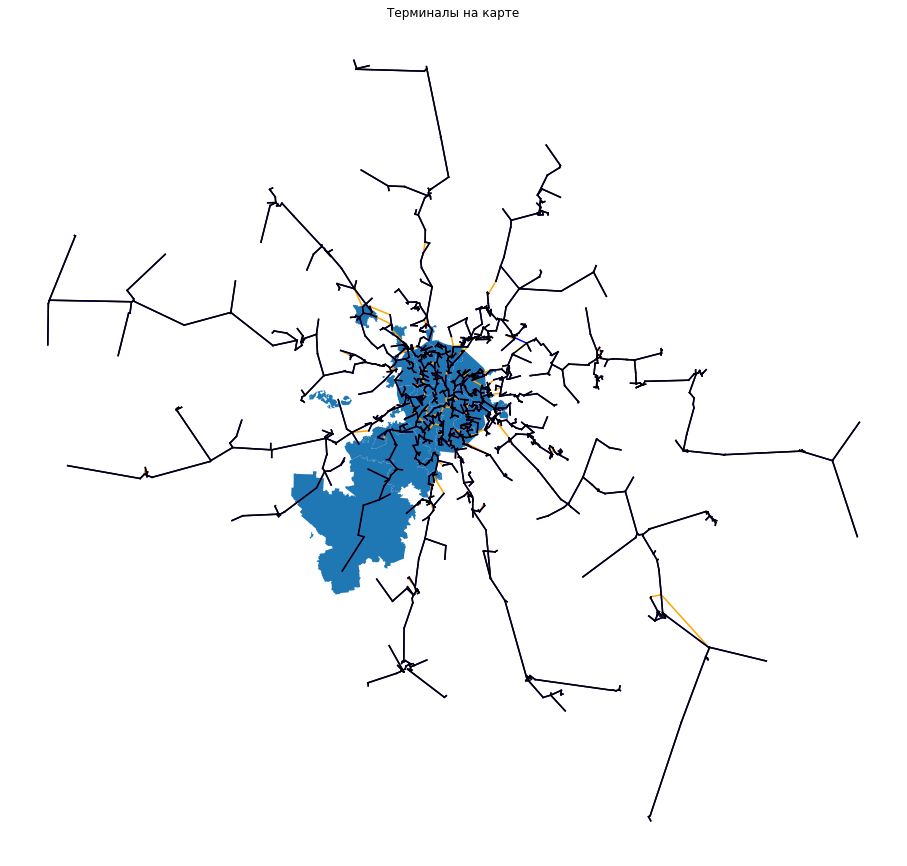

In [94]:
moscow = gpd.read_file('ao-shape.zip')

idx = np.arange(1630)
fig, ax = plt.subplots(figsize=(16, 16))
moscow.plot(ax=ax)

for route in edges1:
    plt.plot(terminals['longitude'].iloc[route], terminals['latitude'].iloc[route], c='orange')

for route in edges2:
    plt.plot(terminals['longitude'].iloc[route], terminals['latitude'].iloc[route], c='blue')

for route in edges3:
    plt.plot(terminals['longitude'].iloc[route], terminals['latitude'].iloc[route], c='black')

plt.axis('off')
plt.title('Терминалы на карте')
plt.show()

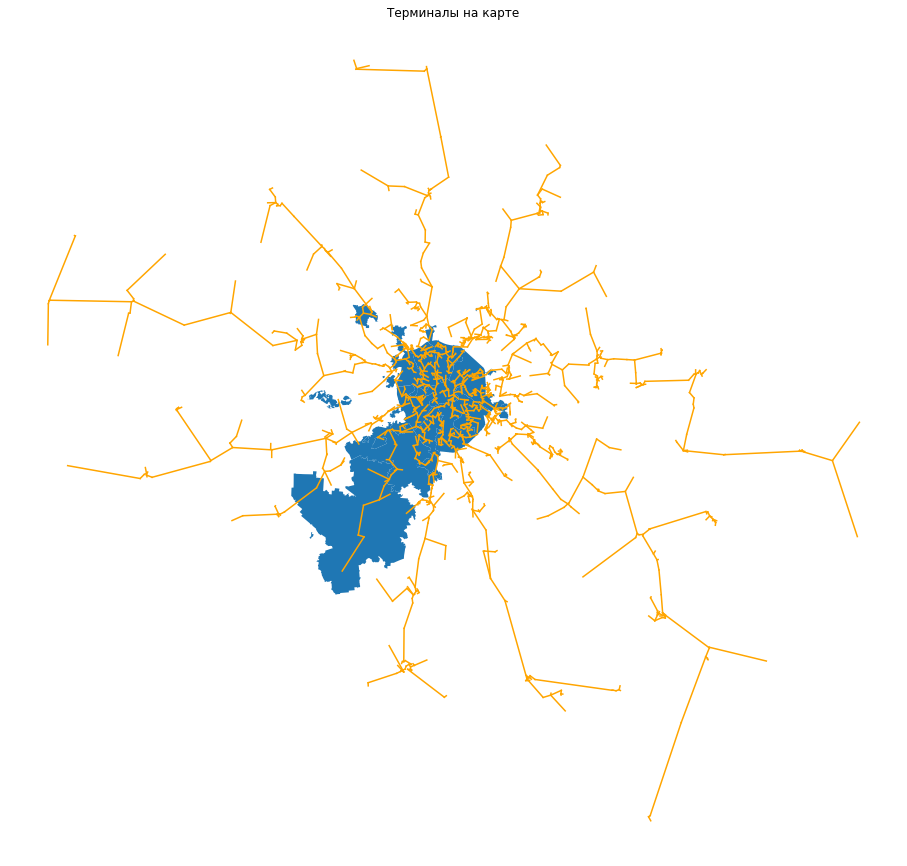

In [66]:
moscow = gpd.read_file('ao-shape.zip')

idx = np.arange(1630)
fig, ax = plt.subplots(figsize=(16, 16))
moscow.plot(ax=ax)

for route in edges:
    plt.plot(terminals['longitude'].iloc[route], terminals['latitude'].iloc[route], c='orange')

plt.axis('off')
plt.title('Терминалы на карте')
plt.show()